# Active Inference Interoception Model

In this notebook, I will lay out the mathematics and implementation of an active inference model of interoception, based on Karl Friston's Free Energy Principle. The model is inspired by Bogacz's tutorial for modeling perception using active inference. The implementation is borrowed and edited from Andre van Schaik's Jupyter notebook conversion of the article. I will be explicit about which code is borrowed and which is original.

### Assumptions and variables for the insula model
In the first model below, assume there is a single variable inferred from a single observation. In our example, we can assume that the agent is inferring the length of breath inhalation (interoceptive ability), $v$, on the basis of interoceptive signals observed, $u$.

For these models, we can assume the sensory input is noisy, so when the breath inhale length is $v$, the perceived interoceptive signalis normally distributed with mean $g(v)$ and variance $\Sigma_u$.

Below are the sybmols used in the model:

$v$ = length of breath inhalation

$g(v)=v^2$ = non-linear function relating average interoceptive signal with breath inhalation length. (more research here)

$v_p$ = mean length of breath inhalation (prior)

$\Sigma_p$ = variance of length of breath inhalation (prior)

$u$ = interoceptive signal observed

$\Sigma_u$ = variance in interoceptive signal, basically noise

$\phi$ = approximation of most likely length of breath inhalation

Currently, we will use a normal distribution, which is probably not realistic for breath inhalation length

$$p(\phi) = f(\phi; v_p, \Sigma_p)$$

$$p(u|\phi) = f(u;g(\phi),\Sigma_u)$$

Next, I will write out some derivations from the paper. What do we want to compute? We want to maximize $p(\phi|u)$, which is the probability of the inhale length approximation given the interoceptive signal. This amounts to maximizing:

$$p(\phi|u) = \frac{p(\phi)p(u|\phi)}{p(u)}$$

Since $p(u)$ (denominator) doesn't depend on $\phi$, we can simply maximize the numerator and it will provide the same answer, but un-scaled. Next, we can find the logarithm of the numnerator, which will again provide the same answer, but scaled differently. This is fine, however, since log is monotonic. Call this equation F:

$$F = \ln p(\phi) + \ln p(u|\phi)$$

This function relates to Free Energy. I'll include more here in a bit, but for now that is sufficient. 

We can maximize F by finding the maximum of F's gradient with respect to $\phi$. First, we compute $F$ by substituting the relevant formulas. The following is taken from the paper:

\begin{align*}
F  &= \ln p(\phi) + \ln p(u|\phi) \\
&= \ln f(\phi; v_p,\Sigma_p) + \ln f(u; g(\phi), \Sigma_u) \\
&= \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_p}} \exp \left(-\frac{(\phi - v_p)^2}{2 \Sigma_p}\right)\right] 
+ \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_u}} \exp \left(-\frac{(u - g(\phi))^2}{2 \Sigma_u}\right)\right] \\
&= \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_p - \frac{(\phi - v_p)^2}{2 \Sigma_p} 
+ \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_u - \frac{(u - g(\phi))^2}{2 \Sigma_u} \\
&= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}

Above, C is the constants.

### Simulate the model with the following parameters:

Exercise 1.Assume that our animal observed the light intensity u=2, the level of noise in its receptor is Σu=1, and the mean and variance of its prior expectation of size are vp=3 and Σp=1. Write a computer program that computes the posterior probabilities of sizes from 0.01 to 5, and plots them.

Initialize $\phi=v_p, \epsilon_p=\epsilon_u=0$

Useful equations: 
$\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\sum_p} + \frac{u-g(\phi)}{\sum_u}g'(\phi)$.
Note that $g(\phi) = 2\phi$

$\dot \phi = \frac{\partial F}{\partial \phi}$

-------------------------------
$\epsilon_p$ = $\frac{\phi-v_p}{\sum_p}$, where $\epsilon_p$ is prediction error between inferred size and prior expectations.

$\epsilon_u$ = $\frac{u-g(\phi)}{\sum_u}$, where $\epsilon_u$ is prediction error between light intensity and expected size of food, $\phi$. So $\phi$ update now simplifies to:

$\dot \phi = \epsilon_u g'(\phi) - \epsilon_p$

-------------------------------

##### Note: Neural implmentation

According to the paper:

$v_p$, $\sum_p$, and $\sum_u$ assumed to be encoded in strengths of synaptic connections.

$\phi$, $\epsilon_u$, and $\epsilon_p$ and sensory input $u$ assumed to be maintained in activity of neurons or neuronal populations.

-------------------------------

Updating prediction errors:

$\dot \epsilon_p = \phi - v_p - \sum_p \epsilon_p$

$\dot \epsilon_u = u - g(\phi) - \sum_u \epsilon_u$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

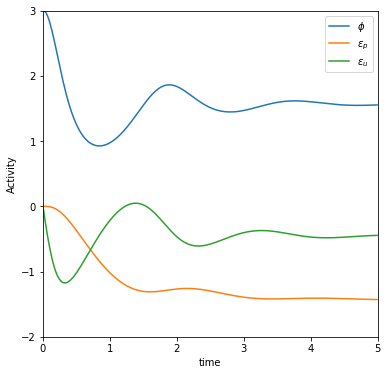

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

def g(phi):
    return phi**2

def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
    return phi - v_p - (sigma * epsilon_p)

def epsilon_u_dot(u, phi, sigma, epsilon_u):
    return u - g(phi) - (sigma * epsilon_u)


def iteration_one_model():
    u       = 2
    sigma_u = 1
    v_p     = 3
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 5
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    trace_phi    = np.zeros(steps)
    trace_phi[0] = phi
    
    trace_epsilon_p = np.zeros(steps)
    trace_epsilon_p[0] = epsilon_p
    
    trace_epsilon_u = np.zeros(steps)
    trace_epsilon_u[0] = epsilon_u

    for t in range(steps-1):
        # First calc phi next timestep
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        trace_phi[t+1] = phi
        
        #calculate epsilons' next timesteps
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        trace_epsilon_p[t+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        trace_epsilon_u[t+1] = epsilon_u

    fig = plt.figure(figsize=(6,6), num='Fig 2b')
    ax  = fig.add_subplot(1, 1, 1)

    ax.plot(np.arange(steps) * dt, trace_phi)
    ax.plot(np.arange(steps) * dt, trace_epsilon_p)
    ax.plot(np.arange(steps) * dt, trace_epsilon_u)
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$'])
    plt.axis([0, 5, -2, 3])
    
iteration_one_model()

### Updating Model Parameters

Next, we will turn to updating the model parameters. This includes variables like $v_p$, $\Sigma_p$, and $\Sigma_u$. We want to update parameters such that the difference between expectation and observation is minimized (predictions are more accurate). This means we must compute the gradient of F with respect to each of these variables to determine their update rules:

\begin{align*}
F &= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}


The calculations are simple:

$$\frac{\partial F}{\partial v_p} = \frac{\phi - v_p}{\Sigma_p}$$

$$\frac{\partial F}{\Sigma_p} = \frac{1}{2} \left( \frac{(\phi-v_p)^2}{\Sigma_p^2} - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\Sigma_u} = \frac{1}{2} \left( \frac{(u-g(\phi))^2}{\Sigma_u^2} - \frac{1}{\Sigma_u} \right)$$

Thus, we get:

$$\frac{\partial F}{\partial v_p} = \epsilon_p$$

$$\frac{\partial F}{\Sigma_p} = \frac{1}{2} \left( \epsilon_p^2 - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\Sigma_u} = \frac{1}{2} \left( \epsilon_u^2 - \frac{1}{\Sigma_u} \right)$$

We will implement the model below, in which parameters are updated:

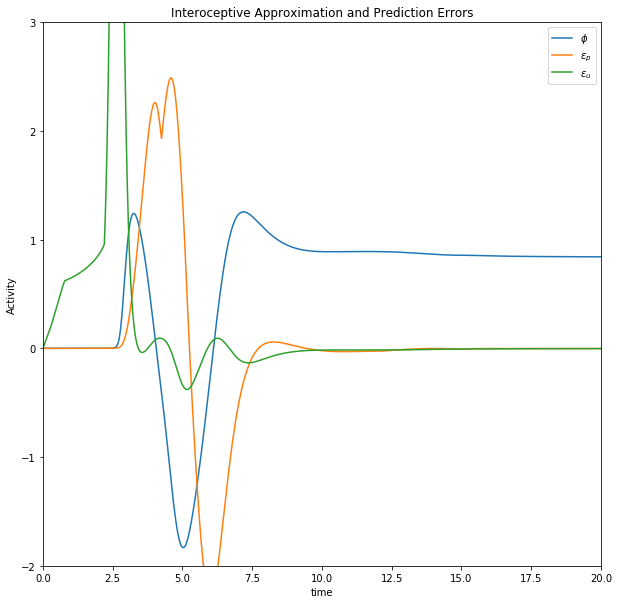

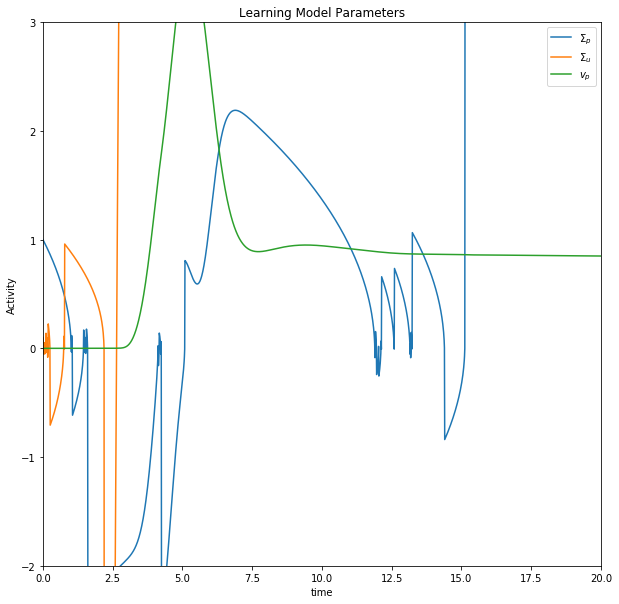

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

def g(phi):
    return phi**2

def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
    return phi - v_p - (sigma * epsilon_p)

def epsilon_u_dot(u, phi, sigma, epsilon_u):
    return u - g(phi) - (sigma * epsilon_u)

def v_p_dot(epsilon_p):
    return epsilon_p

def sigma_p_dot(epsilon_p, sigma_p):
    return (1.0/2.0) * (epsilon_p**2 - (1/sigma_p))

def sigma_u_dot(epsilon_u, sigma_u):
    return (1.0/2.0) * (epsilon_u**2 - (1/sigma_u))

def iteration_two_model():
    u       = .7
    sigma_u = .1
    v_p     = 0.0001
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 20
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    trace_phi    = np.zeros(steps)
    trace_phi[0] = phi
    
    trace_epsilon_p = np.zeros(steps)
    trace_epsilon_p[0] = epsilon_p
    
    trace_epsilon_u = np.zeros(steps)
    trace_epsilon_u[0] = epsilon_u
    
    trace_sigma_p = np.zeros(steps)
    trace_sigma_p[0] = sigma_p
    
    trace_sigma_u = np.zeros(steps)
    trace_sigma_u[0] = sigma_u
    
    trace_v_p = np.zeros(steps)
    trace_v_p[0] = v_p

    for t in range(steps-1):
        # First calc phi next timestep
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        trace_phi[t+1] = phi
        
        #calculate epsilons' next timesteps
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        trace_epsilon_p[t+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        trace_epsilon_u[t+1] = epsilon_u
        
        sigma_p += dt * sigma_p_dot(epsilon_p, sigma_p)
        trace_sigma_p[t+1] = sigma_p
        
        sigma_u += dt * sigma_u_dot(epsilon_u, sigma_u)
        trace_sigma_u[t+1] = sigma_u
        
        v_p += dt * v_p_dot(epsilon_p)
        trace_v_p[t+1] = v_p

    fig = plt.figure(figsize=(10,10), num='Fig 2b')
    ax  = fig.add_subplot(1, 1, 1)

    ax.plot(np.arange(steps) * dt, trace_phi)
    ax.plot(np.arange(steps) * dt, trace_epsilon_p)
    ax.plot(np.arange(steps) * dt, trace_epsilon_u)
    
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$',r'$\Sigma_p$', r'$\Sigma_u$', r'$v_p$'])
    plt.axis([0, dur, -2, 3])
    plt.title('Interoceptive Approximation and Prediction Errors')
    
    fig2 = plt.figure(figsize=(10,10))
    plt.plot(np.arange(steps) * dt, trace_sigma_p)
    plt.plot(np.arange(steps) * dt, trace_sigma_u)
    plt.plot(np.arange(steps) * dt, trace_v_p)
    
    
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\Sigma_p$', r'$\Sigma_u$', r'$v_p$'])
    plt.title('Learning Model Parameters')
    plt.axis([0, dur, -2, 3])
    
iteration_two_model()

##### Emotion Regulation model, first iteration

This model integrates other important emotional regulatory networks. In particular, it adds the amygdala (salience), executive control (prefrontal cortex), and autonomic system. 

Below, I'm going to sketch out the mathematical dynamics of the model first, as I try to figure out how to implement salience and executive control into the model

### Mathematics + Derivations

Currently, we will use a normal distribution, which is probably not realistic for breath inhalation length

$$p(\phi) = f(\phi; v_p, \Sigma_p)$$

$$p(u|\phi) = f(u;g(\phi),\Sigma_u)$$

Next, I will write out some derivations from the paper. What do we want to compute? We want to maximize $p(\phi|u)$, which is the probability of the inhale length approximation given the interoceptive signal. This amounts to maximizing:

$$p(\phi|u) = \frac{p(\phi)p(u|\phi)}{p(u)}$$

Since $p(u)$ (denominator) doesn't depend on $\phi$, we can simply maximize the numerator and it will provide the same answer, but un-scaled. Next, we can find the logarithm of the numnerator, which will again provide the same answer, but scaled differently. This is fine, however, since log is monotonic. Call this equation F:

$$F = \ln p(\phi) + \ln p(u|\phi)$$

This function relates to Free Energy. I'll include more here in a bit, but for now that is sufficient. 

We can maximize F by finding the maximum of F's gradient with respect to $\phi$. First, we compute $F$ by substituting the relevant formulas. The following is taken from the paper:

\begin{align*}
F  &= \ln p(\phi) + \ln p(u|\phi) \\
&= \ln f(\phi; v_p,\Sigma_p) + \ln f(u; g(\phi), \Sigma_u) \\
&= \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_p}} \exp \left(-\frac{(\phi - v_p)^2}{2 \Sigma_p}\right)\right] 
+ \ln \left[ \frac{1}{\sqrt{2 \pi \Sigma_u}} \exp \left(-\frac{(u - g(\phi))^2}{2 \Sigma_u}\right)\right] \\
&= \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_p - \frac{(\phi - v_p)^2}{2 \Sigma_p} 
+ \ln \frac{1}{\sqrt{2 \pi}} - \frac{1}{2} \ln \Sigma_u - \frac{(u - g(\phi))^2}{2 \Sigma_u} \\
&= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}

Above, C is the constants.

Initialize $\phi=v_p, \epsilon_p=\epsilon_u=0$

Useful equations: 
$\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\sum_p} + \frac{u-g(\phi)}{\sum_u}g'(\phi)$.
Note that $g(\phi) = 2\phi$

$\dot \phi = \frac{\partial F}{\partial \phi}$

### Updating model parameters:

\begin{align*}
F &= \frac{1}{2} \left( -\ln \varSigma_p - \frac{(\phi - v_p)^2}{\Sigma_p} - \ln \Sigma_u - \frac{(u - g(\phi))^2}{\Sigma_u} \right) + C. 
\end{align*}


The calculations are simple:

$$\frac{\partial F}{\partial v_p} = \frac{\phi - v_p}{\Sigma_p}$$

$$\frac{\partial F}{\partial \Sigma_p} = \frac{1}{2} \left( \frac{(\phi-v_p)^2}{\Sigma_p^2} - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\partial \Sigma_u} = \frac{1}{2} \left( \frac{(u-g(\phi))^2}{\Sigma_u^2} - \frac{1}{\Sigma_u} \right)$$

Thus, we get:

$$\frac{\partial F}{\partial v_p} = \epsilon_p$$

$$\frac{\partial F}{\partial \Sigma_p} = \frac{1}{2} \left( \epsilon_p^2 - \frac{1}{\Sigma_p} \right)$$

$$\frac{\partial F}{\partial \Sigma_u} = \frac{1}{2} \left( \epsilon_u^2 - \frac{1}{\Sigma_u} \right)$$

$$\frac{\partial F}{\partial \phi} = \frac{v_p - \phi}{\sum_p} + \frac{u-g(\phi)}{\sum_u}g'(\phi)$$

Note that $g(\phi) = 2\phi$

## Free Energy in the Amygdala [NOT USED IN EMOTION REGULATION MODEL]

$\beta$ = magnitute of excitation for autonomic control

$t$ = actual threat signal

$e$ = noisy threat signal recieved

$v_A$ = prior mean for magnitude of autonomic control signal

$\Sigma_A$ = prior variance for magnitude of autonomic control signal

$\mu_t$ = $h(t) = t^2$

##### -------------------------------------------------------
##### Verify this section later

We can get a function called $h()$ which takes in the threat signal, $t$, and linearly scales it. So $h(t) = t^2$
##### -------------------------------------------------------
Assume the incoming threat signal is noisy. The average threat signal received is $\mu_t$, and the variance is denoted $\Sigma_t$. 

Then to figure out the exact posterior probability distribution of the actual signal, we have:

$$p(t|e) = \frac{p(t)p(e|t)}{p(e)}$$

As mentioned in Bogascz, computing $p(e)$ is difficult, so we can find the value $\beta$ which maximizes $p(v|e)$. We get:

$$p(\beta|e) = \frac{p(\beta)p(e|\beta)}{p(e)}$$

We can focus on solely the numerator, which allows us to get $F_t$:

$$F_t = \ln p(\beta) + \ln p(e|\beta)$$

\begin{align*}
F_t &= \ln p(\beta) + \ln p(e|\beta) \\
&= \ln f(\beta; v_A, \Sigma_A) + f(e; \mu_t,\Sigma_t) \\
&= ... \\
&= \frac{1}{2} \left( -\ln \Sigma_A - \frac{(\beta - v_A)^2}{\Sigma_A} - \ln \Sigma_t - \frac{(e - g(\beta))^2}{\Sigma_t} \right) + C
\end{align*}



# Dynamical emotional regulation with active inference interoception

In this iteration, the weights do not update during the simulation of dynamical system. 

body initial state: 0.1892410344295824
prefrontal cortex initial state: 0.3020308699581714


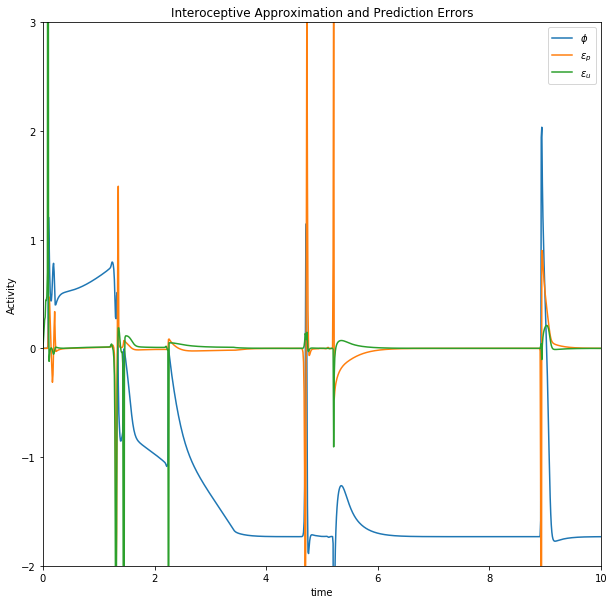

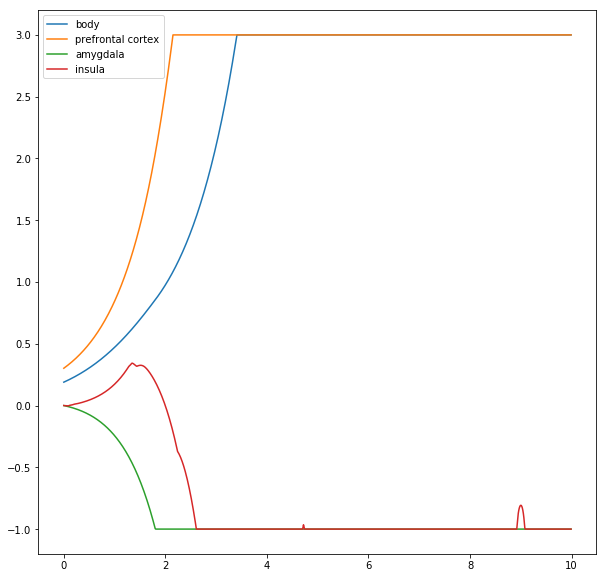

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
import matplotlib

# This function will run a mini simulation in which insula finds most likely interoceptive signal to output
# based on priors and the incoming noisy signal
def interoceptive_update(time_data, t, dt, u):
    
    def g(phi):
        return phi**2

    def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
        return phi - v_p - (sigma * epsilon_p)

    def epsilon_u_dot(u, phi, sigma, epsilon_u):
        return u - g(phi) - (sigma * epsilon_u)

    def v_p_dot(epsilon_p):
        return epsilon_p

    def sigma_p_dot(epsilon_p, sigma_p):
        return (1.0/2.0) * (epsilon_p**2 - (1/sigma_p))

    def sigma_u_dot(epsilon_u, sigma_u):
        return (1.0/2.0) * (epsilon_u**2 - (1/sigma_u))
    
    # First calc phi next timestep
    phi = time_data[0,t]
    epsilon_p = time_data[1,t]
    epsilon_u = time_data[2,t]
    sigma_p = time_data[3,t]
    sigma_u = time_data[4,t]
    v_p = time_data[5,t]
    
    # Here we run a mini simulation that allows the insula to converge on the most likely
     # value for the incoming data. 
     # Then, we update the time_data matrix at the next timestep 
     # with all the values that were converged to at the end of the mini sim
    
    num_steps = 50
    converge_data  = np.zeros((6,num_steps))
    
    for time in range(num_steps-1):
    
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        converge_data[0,time+1] = phi
    
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        converge_data[1,time+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        converge_data[2,time+1] = epsilon_u
        
        sigma_p += dt * sigma_p_dot(epsilon_p, sigma_p)
        converge_data[3,time+1] = sigma_p
    
        sigma_u += dt * sigma_u_dot(epsilon_u, sigma_u)
        converge_data[4,time+1] = sigma_u
    
        v_p += dt * v_p_dot(epsilon_p)
        converge_data[5,time+1] = v_p
    
    # Finally, update the next timestep in time_data with the most recent values from converge_data
    time_data[0,t+1] = converge_data[0,num_steps-1]
    time_data[1,t+1] = converge_data[1,num_steps-1]
    time_data[2,t+1] = converge_data[2,num_steps-1]
    time_data[3,t+1] = converge_data[3,num_steps-1]
    time_data[4,t+1] = converge_data[4,num_steps-1]
    time_data[5,t+1] = converge_data[5,num_steps-1]
    
    return time_data

def slimit(vector, thresh=2, negthresh=0):
    logval = np.clip(vector, negthresh,thresh)
    return logval

def simulation():
    
    #initial values for interoceptive free energy
    u       = 0.7
    sigma_u = 0.1
    v_p     = 0.0001 #can't be zero - dF/dphi vanishes always if phi is zero
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 10
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    # Timestep array, holds most likely val, PEs, and parameters
    # row 0: phi
    # row 1: epsilon_p
    # row 2: epsilon_u
    # row 3: sigma_p
    # row 4: sigma_u
    # row 5: v_p
    time_data = np.zeros((6, steps))
    
    # initialize first values in interoceptive matrix
    time_data[0,0] = phi
    time_data[1,0] = epsilon_p
    time_data[2,0] = epsilon_u
    time_data[3,0] = sigma_p
    time_data[4,0] = sigma_u
    time_data[5,0] = v_p
    
    # Constant values for indexing into weights array
    BODY = 0
    PREFRONTAL_CORTEX = 1
    AMYGDALA = 2
    INSULA = 3
    
    # weight matrix of connections between networks
    weights = np.array([[0.99, 0,   0.3,    0],  # body
                        [0,  0.99,  -0.3,    0],     # prefrontal cortex 
                        [0,  -0.3,  0.99, 0],    # amygdala
                        [u,  -0.1,   0,    0.99]]) # insula
    
    # Second timestep array, holds body/control/salience/interoception values
    # row 0: body
    # row 1: prefrontal cortex
    # row 2: amygdala
    # row 3: insula
    
    networks_time_data = np.zeros((4, steps))
    networks_time_data[0,0] = np.random.rand()-0.5
    networks_time_data[1,0] = np.random.rand()-0.5
    networks_time_data[2,0] = 0
    networks_time_data[3,0] = phi
    
    print('body initial state: ' + str(networks_time_data[0,0]))
    print('prefrontal cortex initial state: ' + str(networks_time_data[1,0]))
    
    # ---------------- SIMULATION ------------------- 
    
    for t in range(steps-1):
        # first, get the current value of u (interoceptive signal from the body)
        u = networks_time_data[BODY, t]
        
        # simulate interoceptive prediction (give it time to converge to some value)
        time_data = interoceptive_update(time_data, t, dt, u)
        
        # get the current phi prediction generated from interoceptive_update
        phi = time_data[0,t+1]
        
        #update phi value in the weight matrix
        weights[INSULA, BODY] = phi
        
        #update dynamics of the system
        networks_time_data[:,t+1] = slimit(networks_time_data[:,t] + \
                                           dt * np.matmul(networks_time_data[:,t], weights.T).T,3,-1)
        
    # ------------- END OF SIMULATION ---------------    
        
    fig = plt.figure(figsize=(10,10), num='Fig a')
    ax  = fig.add_subplot(1, 1, 1)

    # plot interceptive predictions
    for j in range(3):
        ax.plot(np.arange(steps) * dt, time_data[j,:])
    
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$',r'$\Sigma_p$', r'$\Sigma_u$', r'$v_p$'])
    plt.axis([0, 10, -2, 3])
    plt.title('Interoceptive Approximation and Prediction Errors')
    
    # plot system dynamics
    fig2 = plt.figure(figsize=(10,10), num='Fig b')
    ax2 = fig2.add_subplot(1,1,1)
    for k in range(4):
        ax2.plot(np.arange(steps) * dt, networks_time_data[k,:])
        
    plt.legend(['body', 'prefrontal cortex', 'amygdala', 'insula'])
    
simulation()

## Introducing external percepts into the model (threats)

In the above model, there were no external threats that were introduced to the emotional regulation model. Now, we will introduce threats and percepts into the model.

body initial state: -0.29765196668217353
prefrontal cortex initial state: -0.4783178385081672
[0.  0.5 0.5 0.5]
[0.  0.5 0.5 0. ]
[0.  0.5 0.  0.5]
[0.  0.5 0.  0. ]
[0.  0.5 0.5 0.5]
[0.  0.5 0.5 0. ]
[0.  0.5 0.  0.5]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.



[0.  0.5 0.  0. ]


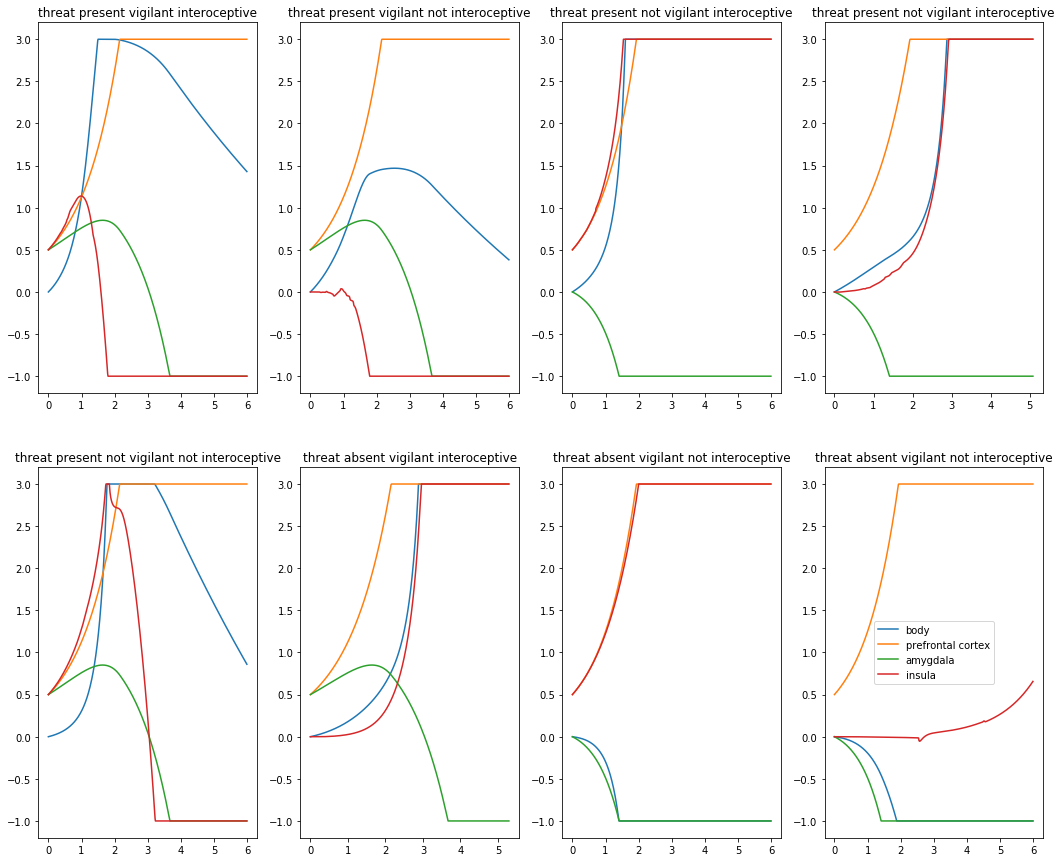

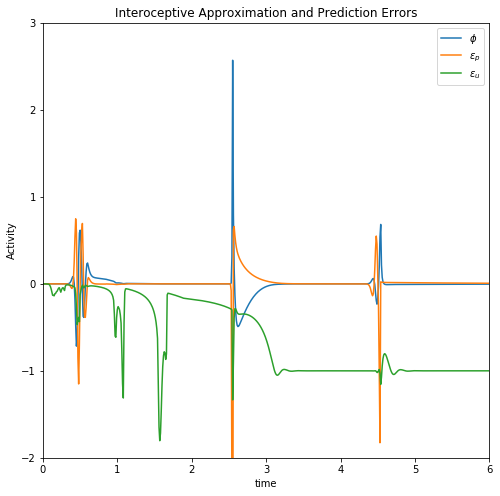

In [4]:
def interoceptive_update(time_data, t, dt, u):
    
    def g(phi):
        return phi**2

    def epsilon_p_dot(phi, v_p, sigma, epsilon_p):
        return phi - v_p - (sigma * epsilon_p)

    def epsilon_u_dot(u, phi, sigma, epsilon_u):
        return u - g(phi) - (sigma * epsilon_u)

    def v_p_dot(epsilon_p):
        return epsilon_p

    def sigma_p_dot(epsilon_p, sigma_p):
        return (1.0/2.0) * (epsilon_p**2 - (1/sigma_p))

    def sigma_u_dot(epsilon_u, sigma_u):
        return (1.0/2.0) * (epsilon_u**2 - (1/sigma_u))
    
    # First calc phi next timestep
    phi = time_data[0,t]
    epsilon_p = time_data[1,t]
    epsilon_u = time_data[2,t]
    sigma_p = time_data[3,t]
    sigma_u = time_data[4,t]
    v_p = time_data[5,t]
    
    # Here we run a mini simulation that allows the insula to converge on the most likely
     # value for the incoming data. 
     # Then, we update the time_data matrix at the next timestep 
     # with all the values that were converged to at the end of the mini sim
    
    num_steps = 50
    converge_data  = np.zeros((6,num_steps))
    
    for time in range(num_steps-1):
    
        phi += dt * (epsilon_u * 2*phi - epsilon_p)
        converge_data[0,time+1] = phi
    
        epsilon_p += dt * epsilon_p_dot(phi, v_p, sigma_p, epsilon_p)
        converge_data[1,time+1] = epsilon_p
        
        epsilon_u += dt * epsilon_u_dot(u, phi, sigma_u, epsilon_u)
        converge_data[2,time+1] = epsilon_u
        
        sigma_p += dt * sigma_p_dot(epsilon_p, sigma_p)
        converge_data[3,time+1] = sigma_p
    
        sigma_u += dt * sigma_u_dot(epsilon_u, sigma_u)
        converge_data[4,time+1] = sigma_u
    
        v_p += dt * v_p_dot(epsilon_p)
        converge_data[5,time+1] = v_p
    
    # Finally, update the next timestep in time_data with the most recent values from converge_data
    time_data[0,t+1] = converge_data[0,num_steps-1]
    time_data[1,t+1] = converge_data[1,num_steps-1]
    time_data[2,t+1] = converge_data[2,num_steps-1]
    time_data[3,t+1] = converge_data[3,num_steps-1]
    time_data[4,t+1] = converge_data[4,num_steps-1]
    time_data[5,t+1] = converge_data[5,num_steps-1]
    
    return time_data

def slimit(vector, thresh=2, negthresh=0):
    logval = np.clip(vector, negthresh,thresh)
    return logval

def external_percept_simulation():
    
    #initial values for interoceptive active inference
    u       = 0.7
    sigma_u = 0.1
    v_p     = 0.0001 #can't be zero - dF/dphi vanishes always if phi is zero
    sigma_p = 1
    phi     = v_p
    dt      = 0.01
    dur     = 6
    steps   = int(dur/dt)
    epsilon_p = 0
    epsilon_u = 0

    # Timestep array, holds most likely val, PEs, and parameters
    # row 0: phi
    # row 1: epsilon_p
    # row 2: epsilon_u
    # row 3: sigma_p
    # row 4: sigma_u
    # row 5: v_p
    time_data = np.zeros((6, steps))
    
    # initialize first values in interoceptive matrix
    time_data[0,0] = phi
    time_data[1,0] = epsilon_p
    time_data[2,0] = epsilon_u
    time_data[3,0] = sigma_p
    time_data[4,0] = sigma_u
    time_data[5,0] = v_p
    
    # Constant values for indexing into weights array
    BODY = 0
    PREFRONTAL_CORTEX = 1
    AMYGDALA = 2
    INSULA = 3
    
    # we need to introduce external percepts here - threat will excite amygdala
    percept = np.array([0, 0, 0.3, 0])
    
    # six combinations of possibilities
    #     1) threat absent vigilant interoceptive
    #     2) threat present vigilant interoceptive
    #     3) threat absent not vigilant interoceptive
    #     4) threat present not vigilant not interoceptive
    #     5) threat absent vigilant not interoceptive
    #     6) threat present not vigilant not interoceptive
    
    startstates = np.array([[0, 0.5, .5, 0.5], # 1) threat present vigilant int
                           [0, 0.5, .5, 0],    # 2) threat present vigilant not int
                           [0, 0.5, 0, 0.5],  # 3) threat present not vigilant int
                           [0, 0.5, 0, 0],    # 4) threat present not vigilant not int
                           [0, 0.5, .5, 0.5],  # 5) threat absent vigilant int
                           [0, 0.5, .5, 0],    # 6) threat absent vigilant not int
                           [0, 0.5, 0, 0.5],  # 7) threat absent not vigilant int
                           [0, 0.5, 0, 0]])   # 8) threat present vigilant not interoceptive
    
    # threat affects the amygdala -> excites the amygdala
    instates= np.array([[0.1, 0, 0, 0],
                       [0.1, 0, 0, 0], 
                       [0.1, 0, 0, 0],  
                       [0.1, 0, 0, 0], 
                       [0, 0, 0, 0],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0],
                       [0, 0, 0, 0]]) 

    # array of the above six states
    instatenames=np.array(['threat present vigilant interoceptive',
                           'threat present vigilant not interoceptive',
                           'threat present not vigilant interoceptive',
                           'threat present not vigilant not interoceptive',
                           'threat absent vigilant interoceptive', 
                           'threat absent vigilant not interoceptive',
                           'threat absent not vigilant interoceptive',
                           'threat absent not vigilant not interoceptive'])
    
    # weight matrix of connections between networks
    #                            TO ?
    weights = np.array([[0.9, -0.1,   0.3,    0.1],    # body
                        [0,  0.9,  -0.1,    0],   # prefrontal cortex     FROM ?
                        [0,  -0.4,  0.9, 0],      # amygdala
                        [u,  0 ,   0,    0.9]]) # insula
    
    random_weights = np.random.rand(4,4)
    
    # Second timestep array, holds body/control/salience/interoception values
    # row 0: body
    # row 1: prefrontal cortex
    # row 2: amygdala
    # row 3: insula
    
    networks_time_data = np.zeros((4, steps))
    networks_time_data[0,0] = np.random.rand()-0.5
    networks_time_data[1,0] = np.random.rand()-0.5
    networks_time_data[2,0] = 0
    networks_time_data[3,0] = phi
    
    print('body initial state: ' + str(networks_time_data[0,0]))
    print('prefrontal cortex initial state: ' + str(networks_time_data[1,0]))
    
    #possible interesting values...
    # body initial: -0.25102011563253956
    # PFC initial: -0.05979777132863817
    
    # make 3-D matrix for storing all the data.
    # there will be six layers of (4 x steps) matrices. 
    # each layer will hold some combination (ie 'threat absent not vigilant interoceptive')
    # the 4 x steps will be the time data for each of the 4 networks (amygdala, insula, PFC, body)
    circuit_situational_data = np.zeros((8,4,steps))
    
    # ---------------- SIMULATION ------------------- 
    
    for curr_state in range(len(instates)):
        
        perception = 3 * dt * instates[curr_state,:]
        circuit_situational_data[curr_state,:,0] = startstates[curr_state,:]
        
        # print the starting states
        print(startstates[curr_state,:])

        for t in range(steps-1):
            
            # first, get the current value of u
            u = circuit_situational_data[curr_state, BODY,t]         
        
            # simulate interoceptive prediction (give it time to converge to some value)
            time_data = interoceptive_update(time_data, t, dt, u)
        
            # get the current phi prediction generated from interoceptive_update
            phi = time_data[0,t+1]
        
            # update body signal value in the weight matrix
            weights[BODY,INSULA] = u
            
            # update phi value in the weight matrix
            weights[INSULA, BODY] = phi
            
            circuit_situational_data[curr_state, :, t+1] = slimit(perception + \
                                                        circuit_situational_data[curr_state,:,t] + \
                                    dt * np.matmul(circuit_situational_data[curr_state,:,t], weights.T).T,3,-1)
        
    
    # ------------- END OF SIMULATION ---------------    
    
    #plot all network data
    fig, axs = plt.subplots(2,4,figsize=(18,15))
    
    for brain_network in range(4):
        axs[0, 0].plot(np.arange(steps) * dt, circuit_situational_data[0,brain_network,:])
    axs[0,0].set_title(instatenames[0])
    
    for brain_network in range(4):
        axs[0, 1].plot(np.arange(steps) * dt, circuit_situational_data[1,brain_network,:])
    axs[0,1].set_title(instatenames[1])
    
    for brain_network in range(4):
        axs[0, 2].plot(np.arange(steps) * dt, circuit_situational_data[2,brain_network,:])
    axs[0,2].set_title(instatenames[2])
    
    for brain_network in range(4):
        axs[0, 3].plot(np.arange(steps) * dt, circuit_situational_data[3,brain_network,:])
    axs[0,3].set_title(instatenames[2])
    
    for brain_network in range(4):
        axs[1, 0].plot(np.arange(steps) * dt, circuit_situational_data[4,brain_network,:])
    axs[1,0].set_title(instatenames[3])
    
    for brain_network in range(4):
        axs[1, 1].plot(np.arange(steps) * dt, circuit_situational_data[5,brain_network,:])
    axs[1,1].set_title(instatenames[4])
    
    for brain_network in range(4):
        axs[1, 2].plot(np.arange(steps) * dt, circuit_situational_data[6,brain_network,:])
    axs[1,2].set_title(instatenames[5])
    
    for brain_network in range(4):
        axs[1, 3].plot(np.arange(steps) * dt, circuit_situational_data[7,brain_network,:])
    axs[1,3].set_title(instatenames[5])
    
    plt.legend(['body', 'prefrontal cortex', 'amygdala', 'insula'])
    
    
    fig = plt.figure(figsize=(8,8), num='Fig a')
    ax  = fig.add_subplot(1, 1, 1)

    # plot interceptive predictions
    for j in range(3):
        ax.plot(np.arange(steps) * dt, time_data[j,:])
    
    plt.xlabel('time')
    plt.ylabel('Activity')
    plt.legend([r'$\phi$', r'$\epsilon_p$',r'$\epsilon_u$',r'$\Sigma_p$', r'$\Sigma_u$', r'$v_p$'])
    plt.axis([0, dur, -2, 3])
    plt.title('Interoceptive Approximation and Prediction Errors')
    
external_percept_simulation()

## Future developments
Is there a combination of weights that leads to wave-like dynbamics?

verify the matrix multiplication?

Figure out why the nans appear occasionally... has to do with np.matmul(). ALso only occurs for interoceptive subgraphs